## Solve LQG B Eq. using WENO recontruction method

We solve the eq.
$$
\partial_t B(x, t) + \partial_x f(B) = 0, \qquad f(B) = \frac{1}{2} x^3 \sin^2 \left( \frac{B}{x^2} \right) 
$$
using WENOr2 and WENOr3 reconstruction methods to capture shocks in the B(x,t) field.

$$
\partial_B f(B) = \frac{1}{2} x \sin(2\frac{B}{x^2})
$$

### Initial data:

$$
B(x, 0) = - \frac{x^2}{2} \arccos\left( 1 - 4\frac{M(x)}{x^3} \right), \qquad M(x) = 4\pi\int_0^x \rho(y)y^2 dy 
$$
where
$$
\rho(x) = \frac{m}{\frac{4}{3}\pi r_0^3} \left( 1 - \theta(x - r_0)  \right), \quad \theta = \begin{cases} 0&\text{ if }x \leq r_0\\1&\text{ if }x \gt r_0\end{cases}
$$
and $m = 5$, $r_0 = 15$.

In general
$$
\rho(x, t) = \frac{1}{8\pi x^2} \partial_x\left( x^3 \sin^2 \frac{B}{x^2} \right)
$$
$$
\partial_t {\rho}(x) = \frac{1}{3x^2} \partial_x \left( - x^5 \sin(\frac{B}{x^2})\cos(\frac{B}{x^2}) \right)
$$

In [1]:
import numpy as np
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
from numba import njit, vectorize
import multiprocessing as mp

%matplotlib widget

@njit
def f(u, x):
    return 0.5 * x*x*x * np.sin(u / x/x)**2 

@njit
def fp(u, x):
    return 0.5 * x * np.sin(2 * u /x/x)

In [2]:
def initial_data(x, m, r0, h):

    # rho = 3 * m * (1 - heaviside(xs-r0)) / (4 * np.pi * r0**3)
    # rho = 3 * m / (4*np.pi * r0**3) * (np.pi/2 - np.arctan(xs - r0))/2
    
    # M = 4*np.pi * cumulative_trapezoid(rho * xs*xs, xs, initial=0)
    # print(f'Mass computed at infinity = {np.round(M[-1],3)}')

    M = m * x**3 / r0**3 * heaviside(r0 - x) + m * heaviside(x - r0)

    B0 = - 0.5 * x**2 * np.arccos(1 - 4 * M / x**3)
    B0[0] = 0
    
    return B0

@vectorize
def heaviside(x):
    if x < 0:
        return 0
    elif x > 0:
        return 1
    else:
        return 0.5

In [3]:
@njit
def TDV_RK(r, u_prev, xs, h, dt, nghost):
    if r == 2:
        return TDV_RK3(u_prev, xs, h, dt, nghost)
    elif r == 3:
        return TDV_RK4(u_prev, xs, h, dt, nghost)
    else:
        raise Exception("Order not implemented! r = 2 or 3")

@njit
def L(r, j, u, fup, xs, h, nghost):
    """
    Equation 2.7b

    u  --> array of sol
    xs --> array of grid
    
    x_jm = x_{j - 1/2}
    x_jM = x_{j + 1/2}

    R(r, j  , x_jM, u, fup, xs, h) = f(x_{j + 1/2})
    """
    x_jM = xs[j] + h / 2
    x_jm = xs[j] - h / 2
    if j == nghost:
        o1 = flux( R(r, j  , x_jM, u, fup, xs, h), R(r, j+1, x_jM, u, fup, xs, h), x_jM) 
        o2 = 0
    else:
        o1 = flux( R(r, j  , x_jM, u, fup, xs, h), R(r, j+1, x_jM, u, fup, xs, h), x_jM) 
        o2 = flux( R(r, j-1, x_jm, u, fup, xs, h), R(r, j  , x_jm, u, fup, xs, h), x_jm)
    return - ( o1 - o2 ) / h

@njit
def R(r, j, x_pt, u, fup, xs, h):
    if r == 2:
        return R2(j, x_pt, u, fup, xs, h)
    elif r == 3:
        return R3(j, x_pt, u, fup, xs, h)

@njit
def alpha(r, j, i, u, fup, x, h):
    if r == 2:
        return alpha_r2(j, i, u, fup, x, h)
    elif r == 3:
        return alpha_r3(j, i, u, fup, x, h)

@njit
def interpolants(r, j, x, u, xs, h):
    if r == 2:
        return interp_r2(j, x, u, xs, h)
    elif r == 3:
        return interp_r3(j, x, u, xs, h)

@njit
def SI(r, j, u):
    if r == 2:
        return SI_r2(j, u)
    elif r == 3:
        return SI_r3(j, u)

# @njit
# def flux(a, b, x):
#     """
#     Roe flux function
#     Equation 2.6
#     """
#     u_dec = np.linspace(min(a,b), max(a,b))
#     der = fp(u_dec, x)
#     if np.all(der >= 0):
#         return f(a, x)
#     elif np.all(der < 0):
#         return f(b, x)
#     else:
#         beta = np.max(np.abs(der)) 
#         return 0.5* (f(a, x) + f(b, x) - beta * (b - a))

# @njit
# def flux(a, b, x):
#     """
#     Godunov flux function
#     Equation 2.5
#     """
#     u_dec = np.linspace(np.min(a,b), np.max(a,b), 100)
#     if a <= b:
#         return np.min(f(u_dec, x))
#     elif a > b:
#         return np.max(f(u_dec, x))

@njit
def flux(a, b, x):
    ul = a/x/x
    ur = b/x/x
    FL = 0.5 * x**3 * np.sin(ul)**2 
    FR = 0.5 * x**3 * np.sin(ur)**2 
    ll = np.array([FL, FR])
    if ul <= ur:
        return np.min(ll)
    elif ul > ur:
        if ((ur > -np.pi/2) or (ul < -np.pi/2)):
            return np.max(ll)
        else:
            return 0.5 * x**3


@njit
def BC(arr, val):
    return arr = val


r = 2

In [4]:
@njit
def TDV_RK3(u_prev, xs, h, dt, nghost):
    """
    ## TO OPTIMIZE

    1**) Euler step t      --> t +   dt
    2**) Euler step t + dt --> t + 2*dt
    
    3**) Weighted mean btw t and t+2*dt to find t + dt/2
    
    4**) Euler step t + dt/2 -- > t + 3*dt/2
    
    5**) Weighted mean btw t and t+3*dt/2 to find  t + dt
    """
    lu = len(u_prev)
    u_n1    = np.zeros_like(u_prev)
    u_n2    = np.zeros_like(u_prev)
    u_n12   = np.zeros_like(u_prev)
    u_n32   = np.zeros_like(u_prev)
    u_final = np.zeros_like(u_prev)
    
    for j in range(nghost, lu - nghost):

        fup = fp(u_prev[j], xs[j])
        # 1**)
        rr = L(2, j, u_prev, fup, xs, h, nghost)
        u_n1[j] = u_prev[j] + dt * rr
        if j == lu - nghost - 1:
            u_n1[-nghost:] = BC(u_n1[-nghost:], u_n1[-nghost - 1])
        if j == nghost:
            u_n1[:nghost] = BC(u_n1[:nghost], u_n1[nghost])
        fup = fp(u_n1[j], xs[j])


        # 2**) + 3**)
        rr = L(2, j+nghost, u_n1, fup, xs, h, nghost)
        u_n12[j] = 3 * u_prev[j] / 4 + u_n1[j] / 4 + dt * rr / 4
        if j == lu - nghost - 1:
            u_n12[-nghost:] = BC(u_n12[-nghost:], u_n12[-nghost - 1])
        if j == nghost:
            u_n12[:nghost] = BC(u_n12[:nghost], u_n12[nghost])
        fup = fp(u_n12[j], xs[j])

        # 4**) + 5**)
        rr = L(2, j, u_n12, fup, xs, h, nghost)        
        u_final[j] = u_prev[j] / 3 + 2 * u_n12[j] / 3 + 2 * dt * rr / 3
        if j == lu - nghost - 1:
            u_final[-nghost:] = BC(u_final[-nghost:], u_final[-nghost - 1])
        if j == nghost:
            u_final[:nghost] = BC(u_final[:nghost], u_final[nghost])


    return u_final

@njit
def R2(j, x_pt, u, fup, xs, h):
    """
    Equation 3.16
    """
    aj0 = alpha(2, j, 0, u, fup, x_pt, h)
    aj1 = alpha(2, j, 1, u, fup, x_pt, h)
    d = aj0 + aj1
    w0 = aj0 / d
    w1 = aj1 / d
    out = w0 * interpolants(2, j, x_pt, u, xs, h) + w1 * interpolants(2, j+1, x_pt, u, xs, h)
    return out

@njit
def alpha_r2(j, i, u, fup, x, h, eps = 1e-6):
    """
    Equations 3.17a & 3.17b 
    """
    if fup[j-1] > 0:
        if i == 0:
            return 1 / 2 / (eps + SI(2, j, u))**2
        elif i == 1:
            return 1 / (eps + SI(2, j+1, u))**2
    elif fup[j-1] <= 0:
        if i == 0:
            return 1 / (eps + SI(2, j, u))**2
        elif i == 1:
            return 1 / 2 / (eps + SI(2, j+1, u))**2

@njit
def interp_r2(j, x, u, xs, h):
    return u[j-1] + (u[j] - u[j-1]) * (x - xs[j-1]) / h

@njit
def SI_r2(j, u):
    return (u[j] - u[j-1])**2

r = 3

In [5]:
@njit
def TDV_RK4(u_prev, xs, fup, h, dt, nghost):
    """
    uj_0 = u_prev[j]
    uj_1 = uj_0 + dt * L(uj_0)
    uj_2 = uj_0 / 2 + u_j1 / 2 - dt * L(u_j1) / 4 + dt * L(u_j2) / 2
    u_j3 = uj_0 / 9 + 2 * u_j1 / 9 + 2 * u_j2 / 3 - dt * L(u_j1) / 9 - dt * L(u_j2) / 3 + dt * L(u_j3)
    u_new = u_j1 / 3 + u_j2 / 3 + u_j3 / 3 + dt * L(u_j2) / 6 + dt * L(u_j3) / 6
    """

    r_j1 = np.zeros(len(u_prev) - 2*nghost)
    r_j2 = np.zeros(len(u_prev) - 2*nghost)
    r_j3 = np.zeros(len(u_prev) - 2*nghost)

    u_j1    = np.zeros_like(u_prev)
    u_j2    = np.zeros_like(u_prev)
    u_j3    = np.zeros_like(u_prev)
    u_final = np.zeros_like(u_prev)

    for j in range(len(r_j1)-2):
        r_j1[j] = L(3, j+nghost, u_prev, fup, xs, h, nghost)
    u_j1[nghost] = 0
    u_j1[nghost+1:-nghost] = u_prev[nghost+1:-nghost] + dt*r_j1[1:]
    u_j1 = BC(u_j1, nghost)

    for j in range(len(r_j2)-2):
        r_j2[j] = L(3, j+nghost, u_j1, fup, xs, h, nghost)
    u_j2[nghost] = 0
    u_j2[nghost+1:-nghost] = u_prev[nghost+1:-nghost] / 2 + u_j1[nghost+1:-nghost] / 2 - dt*r_j1[1:] / 4 + dt * r_j2[1:] / 2
    u_j2 = BC(u_j1, nghost)

    for j in range(len(r_j3)-2):
        r_j3[j] = L(3, j+nghost, u_j2, fup, xs, h, nghost)
    u_j3[nghost] = 0
    u_j3[nghost+1:-nghost] = u_prev[nghost+1:-nghost]/9 + 2*u_j1[nghost+1:-nghost]/9 + 2*u_j2[nghost+1:-nghost]/3 - dt*r_j1[1:]/9 - dt*r_j2[1:]/3 + dt*r_j3[1:]
    u_j3 = BC(u_j1, nghost)

    u_final[nghost] = 0
    u_final[nghost+1:-nghost] = u_j1[nghost+1:-nghost]/3 + u_j2[nghost+1:-nghost]/3 + u_j3[nghost+1:-nghost]/3 + dt*r_j2[1:]/6 + dt*r_j3[1:]/6
    return BC(u_final, nghost)

@njit
def R3(j, x_pt, u, fup, xs, h):
    """
    Equation 3.18
    """
    aj0 = alpha(3, j, 0, u, fup, x_pt, h)
    aj1 = alpha(3, j, 1, u, fup, x_pt, h)
    aj2 = alpha(3, j, 2, u, fup, x_pt, h)
    d = aj0 + aj1 + aj2
    r1 = aj0 / d
    r2 = aj1 / d
    r3 = aj2 / d
    out = r1 * interpolants(3, j, x_pt, u, xs, h) + r2 * interpolants(3, j+1, x_pt, u, xs, h) + r3 * interpolants(3, j+2, x_pt, u, xs, h)
    return out

@njit
def alpha_r3(j, i, u, fup, x, h, eps = 1e-5):
    """
    Equations 3.17a & 3.17b 
    """
    if fup[j-2] > 0:
        if i == 0:
            return 1 / 12 / (eps + SI(3, j, u))**3
        elif i == 1:
            return 1 / 2 / (eps + SI(3, j+1, u))**3
        elif i == 2:
            return 1 / 4 / (eps + SI(3, j+2, u))**3
    elif fup[j-2] <= 0:
        if i == 0:
            return 1 / 4 / (eps + SI(3, j, u))**3
        elif i == 1:
            return 1 / 2 / (eps + SI(3, j+1, u))**3
        elif i == 2:
            return 1 / 12 / (eps + SI(3, j+2, u))**3

@njit
def interp_r3(j, x, u, xs, h):
    p1 = (u[j] - 2*u[j-1] + u[j-2]) * (x - xs[j-1])*(x - xs[j-1]) / 2 / h/h 
    p2 = (u[j] - u[j-2]) * (x - xs[j-1]) / 2 / h
    p3 = u[j-1] - (u[j] - 2*u[j-1] + u[j-2]) / 24

    return p1 + p2 + p3

@njit
def SI_r3(j, u):
    p1 = (u[j-1] - u[j-2])**2
    p2 = (u[j] - u[j-1])**2
    p3 = (u[j] - 2*u[j-1] + u[j-2])**2

    return 0.5*(p1 + p2) + p3

In [6]:
@njit
def CLF(u, xs, dx, fact = 0.2):
    # Set dt using velocity of characteristics
    vel = xs * np.sin(u / xs/xs) * np.cos(u / xs/xs)
    v = np.max(np.array([-np.min(vel), np.max(vel)]))

    # CFL condition
    dt = fact * dx / np.abs(v)
    if dt > 0.01*dx:
       dt = 0.01*dx  # largest timestep allowed
    return dt

# @njit
# def CLF_np(u, xs, dx, fact = 0.45):
#     # Set dt using velocity of characteristics
#     vel = xs * np.sin(u / xs**2) * np.cos(u / xs**2)
#     v_abs = np.abs(vel).max()

#     # Compute dt
#     dt = fact * dx / v_abs
#     if dt > 0.02:  # largest timestep allowed
#         dt = 0.02
#     return dt

# dt_np = CLF_np(u_p[nghost:-nghost], x_phys, h)
# dt    = CLF(u_p[nghost:-nghost], x_phys, h)
# np.testing.assert_almost_equal(dt, dt_np)

@njit
def der(f, h):
    f_x = np.zeros_like(f)
    f_x[0:3]   = (-147*f[0:3]+360*f[1:4]-450*f[2:5]+400*f[3:6]-225*f[4:7]+72*f[5:8]-10*f[6:9])/(60*h)
    f_x[-3:] = (10*f[-9:-6]-72*f[-8:-5]+225*f[-7:-4]-400*f[-6:-3]+450*f[-5:-2]-360*f[-4:-1]+147*f[-3:])/(60*h)
    f_x[3:-3]  = (-f[0:-6]+9*f[1:-5]-45*f[2:-4]+45*f[4:-2]-9*f[5:-1]+f[6:])/(60*h)
    return f_x

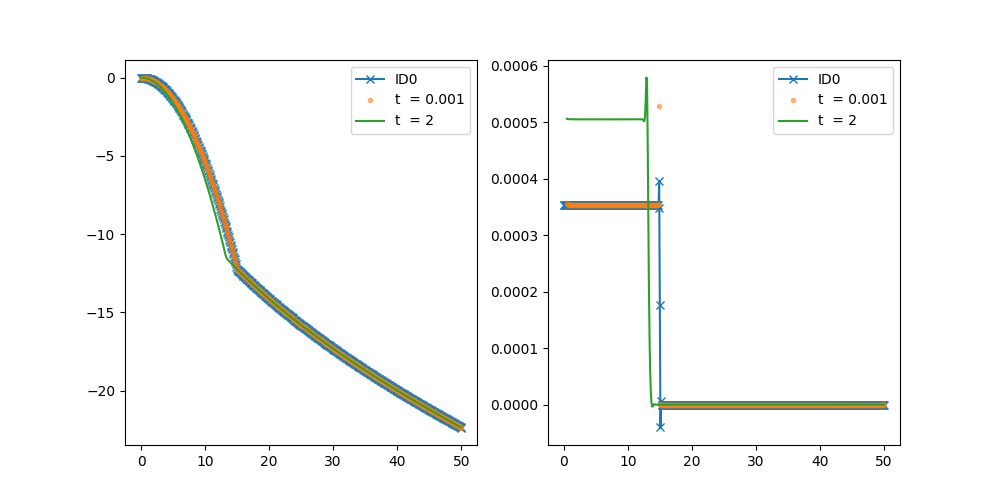

In [8]:
from tqdm.notebook import tqdm



xM = 50
h = 1e-1
t_max =  2

r = 2
m = 5
r0 = 15+0.001*h

if r == 2:
    nghost = 1
elif r == 3:
    nghost = 2

# Grid
nx = int(xM / h + 1 + 2*nghost)
xs = np.array([0.001*h + (i-nghost)*h for i in range(nx)])
x_phys = xs[nghost:-nghost]

# Initial Data
u_p = np.zeros_like(xs)
u_p[nghost:-nghost] = initial_data(x_phys, m, r0, h)
u_p = BC(u_p, nghost)

rhos = np.zeros((len(u_p) - 2*nghost, 2))
Bs = np.zeros_like(rhos)

BID0   = u_p[nghost:-nghost]
rhoID0 = der(x_phys**3 * np.sin(u_p[nghost:-nghost] / x_phys**2)**2, h) / (8 * np.pi * x_phys**2)

t = 0
while t < t_max:
    # Compute dt
    dt = CLF(u_p[nghost:-nghost], x_phys, h)
    # Advance time
    t = t + dt
    if t > t_max:
        dt = t_max - t - dt
        t = t_max
        
    # RK timestep
    u = TDV_RK(r, u_p, xs, h, dt, nghost)

    if t == dt:
        tt = t
        Bs[:,0] = u[nghost:-nghost].copy()
        rhos[:,0] = (u_p[nghost:-nghost] - u[nghost:-nghost]) / x_phys**2 / (4*np.pi*dt)
                    # der(x_phys**3 * np.sin(u[nghost:-nghost] / x_phys**2)**2, h) / (8 * np.pi * x_phys**2)

    # Update old storage variable
    if t < t_max:
        u_p = u.copy()
   
Bs[:,1] = u[nghost:-nghost].copy()
rhos[:,1] = (u_p[nghost:-nghost] - u[nghost:-nghost]) / x_phys**2 / (4*np.pi*dt)
            # der(x_phys**3 * np.sin(u[nghost:-nghost] / x_phys**2)**2, h) / (8 * np.pi * x_phys**2)


fig, axs = plt.subplots(1,2, sharex = True, figsize=(10,5))
axs[0].plot(x_phys, BID0, 'x-', label = 'ID0')
axs[0].plot(x_phys, Bs[:, 0], '.', alpha = 0.5, label = f't  = {np.round(tt,4)}')
axs[0].plot(x_phys, Bs[:, 1], label = f't  = {np.round(t,3)}')
axs[0].legend()

axs[1].plot(x_phys, rhoID0, 'x-',  label = 'ID0')
axs[1].plot(x_phys[5:], rhos[5:, 0], '.',alpha = 0.5, label = f't  = {np.round(tt,4)}')
axs[1].plot(x_phys[5:], rhos[5:, 1], label = f't  = {np.round(t,3)}')
axs[1].legend()

In [ ]:
# def comp_der_loop_6(f, xs, h):
#     f_x = np.zeros_like(f)
#     for i in range(len(xs)):
#         if i in range(3):
#             f_x[i] = (-147*f[i+0]+360*f[i+1]-450*f[i+2]+400*f[i+3]-225*f[i+4]+72*f[i+5]-10*f[i+6])/(60*h)
#         elif i in range(len(xs) - 3, len(xs)):
#             f_x[i] = (10*f[i-6]-72*f[i-5]+225*f[i-4]-400*f[i-3]+450*f[i-2]-360*f[i-1]+147*f[i+0])/(60*h)
#         else:
#             f_x[i] = (-1*f[i-3]+9*f[i-2]-45*f[i-1]+0*f[i+0]+45*f[i+1]-9*f[i+2]+1*f[i+3])/(60*h)
#     return f_x

# def comp_der_v_6(f, h):
#     f_x = np.zeros_like(f)
    
#     f_x[0:3]   = (-147*f[0:3]+360*f[1:4]-450*f[2:5]+400*f[3:6]-225*f[4:7]+72*f[5:8]-10*f[6:9])/(60*h)
#     f_x[-3:] = (10*f[-9:-6]-72*f[-8:-5]+225*f[-7:-4]-400*f[-6:-3]+450*f[-5:-2]-360*f[-4:-1]+147*f[-3:])/(60*h)
#     f_x[3:-3]  = (-f[0:-6]+9*f[1:-5]-45*f[2:-4]+45*f[4:-2]-9*f[5:-1]+f[6:])/(60*h)

#     return f_x

# np.testing.assert_array_almost_equal(comp_der_loop_6(Bs[:, 1], x_phys, h), comp_der_v_6(Bs[:, 1], h))

In [ ]:
# def comp_der_loop_4(f, xs, h):
#     f_x = np.zeros_like(f)
#     for i in range(len(xs)):
#         if i in range(2):
#             f_x[i] = (-25*f[i+0]+48*f[i+1]-36*f[i+2]+16*f[i+3]-3*f[i+4])/(12*1.0*h**1)
#         elif i in range(len(xs) - 2, len(xs)):
#             f_x[i] = (3*f[i-4]-16*f[i-3]+36*f[i-2]-48*f[i-1]+25*f[i+0])/(12*1.0*h**1)
#         else:
#             f_x[i] = (1*f[i-2]-8*f[i-1]+0*f[i+0]+8*f[i+1]-1*f[i+2])/(12*1.0*h**1)
#     return f_x

# def comp_der_v_4(f, h):
#     f_x = np.zeros_like(f)
    
#     f_x[0:2] = (-25*f[0:2]/12+4*f[1:3]-3*f[2:4]+4*f[3:5]/3-f[4:6]/4)/h
#     f_x[-2:] = (25*f[-2:]/12-4*f[-3:-1]+3*f[-4:-2]-4*f[-5:-3]/3+f[-6:-4]/4)/h
#     f_x[2:-2] = (f[0:-4]-8*f[1:-3]+8*f[3:-1]-f[4:])/(12*h)

#     return f_x

# np.testing.assert_array_almost_equal(comp_der_loop_4(Bs[:, 1], xs, h), comp_der_v_4(Bs[:, 1], h))

### Convergence order

In [7]:
import time

r = 2
m = 5
r0 = 15

xM = 50
n_div = 5
h0 = 0.2
hs = [h0 / 2**i for i in range(n_div)]
t_max = 5

if r == 2:
    nghost = 1
elif r == 3:
    nghost = 2


saved = {}

for k, h in enumerate(hs):

    print('h = ', h)
    t1 = time.time()

    # Grid
    nx = int(xM / h + 1 + 2*nghost)
    xs = np.array([0.01*h + (i-nghost)*h for i in range(nx)])
    x_phys = xs[nghost:-nghost]

    # Initial Data
    u_p = np.zeros_like(xs)
    u_p[nghost:-nghost] = initial_data(x_phys, m, r0, h)
    u_p = BC(u_p, nghost)

    # Derivative of f(u)
    fup = fp(u_p[nghost:-nghost], x_phys)

    t = 0
    while t < t_max:
        # Compute dt
        dt = CLF(u_p[nghost:-nghost], x_phys, h)
        # Advance time
        if t + dt > t_max:
            dt = t_max - t
            t = t_max
        else:
            t = t + dt
        
        # RK timestep
        u = TDV_RK(r, u_p, fup, xs, h, dt, nghost)
        # Compute derivative for next cycle
        fup = fp(u[nghost:-nghost], x_phys)
    
        if t != t_max:
            u_p = u.copy()
    
    print(f'Done in {time.time() - t1} s')
    saved[k] = {}
    saved[k]['dx'] = h
    saved[k]['x']  = x_phys
    saved[k]['t']  = t
    saved[k]['B']  = u[nghost:-nghost].copy()
    saved[k]['rho_dx'] = der(x_phys**3 * np.sin(u[nghost:-nghost] / x_phys**2)**2, h) / (8 * np.pi * x_phys**2)
    saved[k]['rho_dt'] = (u_p[nghost:-nghost] - u[nghost:-nghost]) / x_phys**2 / (4*np.pi*dt)

h =  0.2
Done in 8.279098510742188 s
h =  0.1
Done in 2.0981967449188232 s
h =  0.05
Done in 7.098388195037842 s
h =  0.025
Done in 27.12035346031189 s
h =  0.0125
Done in 98.20431303977966 s


In [8]:
# import pickle
# with open('results/weno_multipleRes.pickle', 'wb') as handle:
#     pickle.dump(saved, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
import pickle
with open('results/weno_multipleRes.pickle', 'rb') as handle:
    saved = pickle.load(handle)

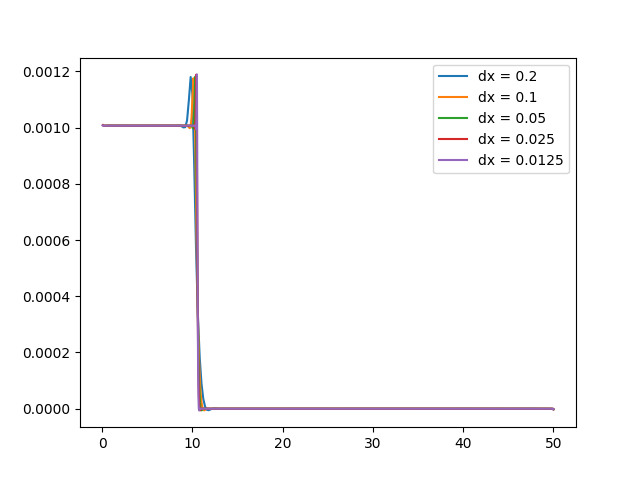

In [10]:
fig = plt.figure()
for k, h in enumerate(hs):
    plt.plot(saved[k]['x'][3:], saved[k]['rho_dx'][3:], label = f"dx = {saved[k]['dx']}")

plt.legend()

In [11]:
from scipy.integrate import simps

for k in range(n_div):
    mass = 4*np.pi*simps(saved[k]['rho_dx']*saved[k]['x']*saved[k]['x'], saved[k]['x'])
    print(f"Total mass computed at time {saved[k]['t']} and dx = {saved[k]['dx']} is {mass}")

Total mass computed at time 5 and dx = 0.2 is 4.999941739773478
Total mass computed at time 5 and dx = 0.1 is 4.999987591456354
Total mass computed at time 5 and dx = 0.05 is 4.999994457675118
Total mass computed at time 5 and dx = 0.025 is 4.9999984174909
Total mass computed at time 5 and dx = 0.0125 is 5.000001700321214


In [12]:
Is = {}

for k in range(n_div-2):
    Is[k] = {}
    Is[k]['h']  = saved[k]['B'][:-1]
    Is[k]['h/2'] = np.array([0.5*(saved[k+1]['B'][i]+saved[k+1]['B'][i+1]) for i in range(0, len(saved[k+1]['B'])-1, 2)])
    Is[k]['h/4'] = np.array([0.25*(saved[k+2]['B'][i]+saved[k+2]['B'][i+1]+saved[k+2]['B'][i+2]+saved[k+2]['B'][i+3]) for i in range(0, len(saved[k+2]['B'])-3, 4)])


p = {}
for k in range(n_div-2):
    p[k] = np.log2( (Is[k]['h'] - Is[k]['h/2']) / (Is[k]['h/2'] - Is[k]['h/4']) )

p_L1 = np.zeros(n_div-2)
for k in range(n_div-2):
    p_L1[k] = np.log2( np.sum(np.abs((Is[k]['h'] - Is[k]['h/2']))) / np.sum(np.abs((Is[k]['h/2'] - Is[k]['h/4']))) )

/tmp/ipykernel_468/2687916188.py:12: RuntimeWarning: invalid value encountered in log2
  p[k] = np.log2( (Is[k]['h'] - Is[k]['h/2']) / (Is[k]['h/2'] - Is[k]['h/4']) )


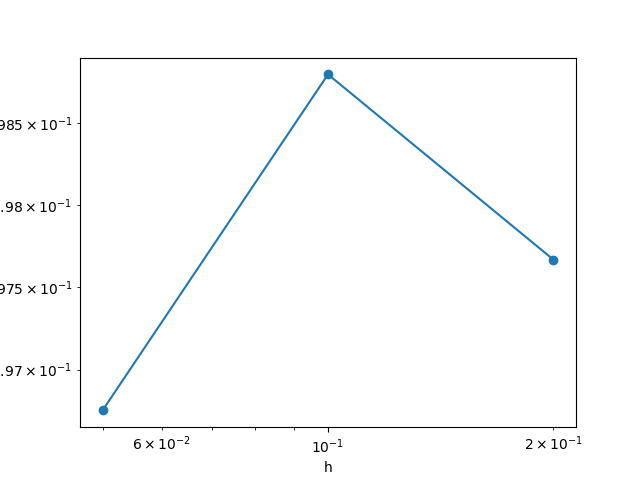

In [13]:
fig = plt.figure()
plt.plot(hs[:n_div-2], p_L1, 'o-')

plt.xlabel('h')
# plt.ylabel(r'$\log_2\left( \frac{ \|\| I_h - I_{h/2} \|\|_1}{\|\|I_{h/2} - I_{h/4}\|\|_1} \right)$')

plt.xscale('log')
plt.yscale('log')

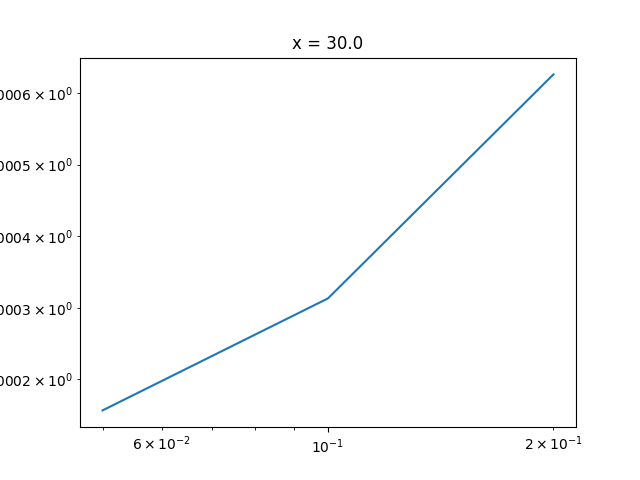

In [14]:
pll = []
hh = []
for k in range(n_div - 2):
    idx = np.argwhere(np.round(saved[k]['x'], 2) == 30.0)[0][0]
    pll.append(p[k][idx])
    hh.append(saved[k]['dx'])

fig = plt.figure()
plt.plot(hh, pll)

plt.title(f"x = {np.round(saved[k]['x'], 2)[idx]}")

plt.xscale('log')
plt.yscale('log')